In [1]:
import pandas as pd
import numpy as np 
from gpxutils import parse_gpx 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Analysis of Cycling Data

We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performace like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

## Description of Fields

* _index_ is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


In [2]:
# read the four data files
rr_2016 = parse_gpx('files/Calga_RR_2016.gpx')
tt_2016 = parse_gpx('files/Calga_TT_2016.gpx')
rr_2019 = parse_gpx('files/Calga_RR_2019.gpx')
tt_2019 = parse_gpx('files/Calga_TT_2019.gpx')

In [3]:
rr_2016.head()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,0.0,40.0,102.0,0.000000,0.0,0.000000,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,0.0,40.0,102.0,0.003271,0.0,11.777020,1.0
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,0.0,40.0,103.0,0.018194,0.0,16.375033,4.0
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,0.0,55.0,106.0,0.017703,0.0,21.243901,3.0
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,0.0,61.0,109.0,0.013001,0.0,23.401217,2.0


In [4]:
rides = [rr_2016, tt_2016, rr_2019, tt_2019]

## Summary for Each Ride
In order to provide a quick summary of each ride, I have set up a function that will print out the following:
* The overall distance of each ride (sums up distnace column and rounds the result to within the meter)
* The total time of each ride (taking away the first time index from the last)
* The average speed of each ride (finds the mean of the speed column)

In [5]:
def summary(dataframe):
    print("The overall distance was: ", round(dataframe["distance"].sum(), 2), "kms", sep = "")
    timeTaken = dataframe.index[len(dataframe.index) - 1] - dataframe.index[0]
    print("The total time taken was: ", timeTaken)
    print("The average speed of the ride was: ", round(dataframe["speed"].mean(), 2), "km/h", sep = "")
    print("\n")
       

We will then run each ride through this function to get a summary

In [6]:
print("--Road Race 1 (2016)--")
summary(rr_2016)
print("--Time Trial 1 (2016)--")
summary(tt_2016)
print("--Road Race 2 (2019)--")
summary(rr_2019)
print("--Time Trial 2 (2019)--")
summary(tt_2019)

--Road Race 1 (2016)--
The overall distance was: 49.05kms
The total time taken was:  0 days 01:26:40
The average speed of the ride was: 34.93km/h


--Time Trial 1 (2016)--
The overall distance was: 24.8kms
The total time taken was:  0 days 00:45:47
The average speed of the ride was: 33.53km/h


--Road Race 2 (2019)--
The overall distance was: 51.79kms
The total time taken was:  0 days 01:31:42
The average speed of the ride was: 33.88km/h


--Time Trial 2 (2019)--
The overall distance was: 24.38kms
The total time taken was:  0 days 00:44:14
The average speed of the ride was: 33.06km/h




## Speed Differences Between Rides
The summaries of each ride provided the average speed of each ride. It is possible that this was not representative as there could have been points of stoppage in each of the rides. In order to get a proper representation of the speed of each ride we will now look at the following:
* An average speed graph of each ride
* The average speed of each ride without very low speeds and or outliers
* The top speed of each ride

## Graphing The Speed of Each Ride

In [39]:
def speedPlot(dataframe):
    plt.xlabel('Time (day hour:minute)')
    plt.ylabel('Speed (km/h)')
    sns.lineplot(data=dataframe, x =dataframe.index - dataframe.index[0], y = 'speed')

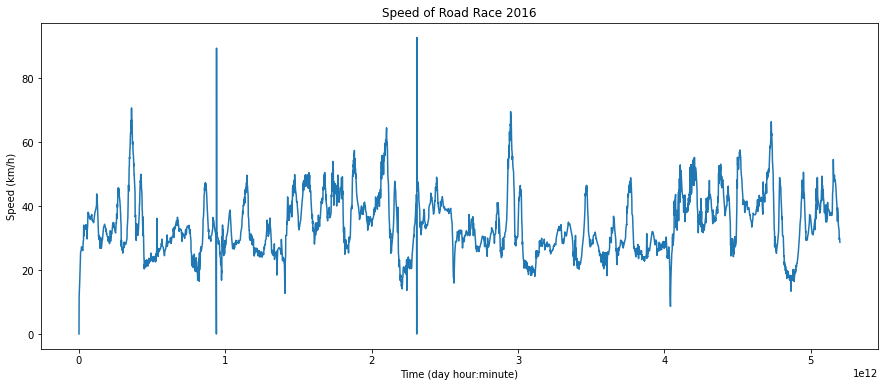

In [40]:
plt.figure(figsize = (15,6))
plt.title('Speed of Road Race 2016')
speedPlot(rr_2016)

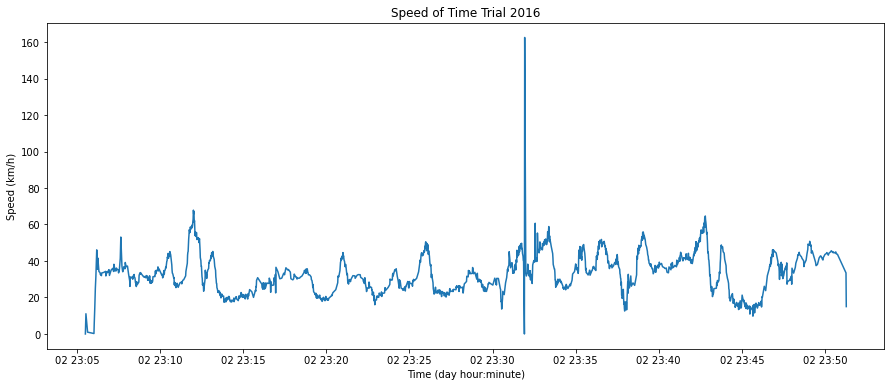

In [35]:
plt.figure(figsize = (15,6))
plt.title('Speed of Time Trial 2016')
speedPlot(tt_2016)

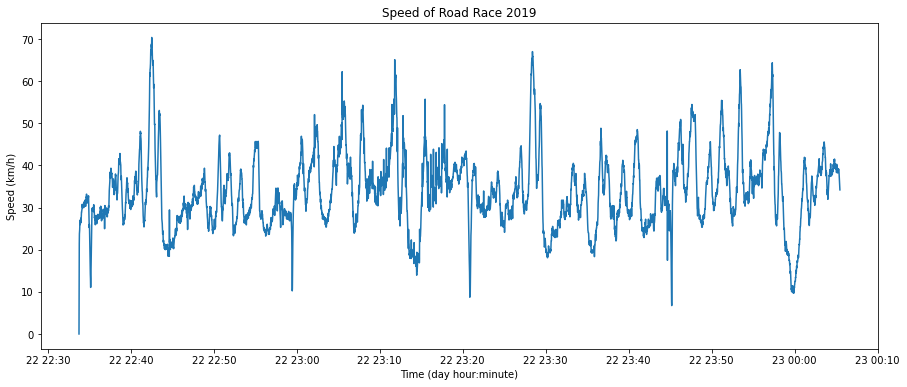

In [36]:
plt.figure(figsize = (15,6))
plt.title('Speed of Road Race 2019')
speedPlot(rr_2019)

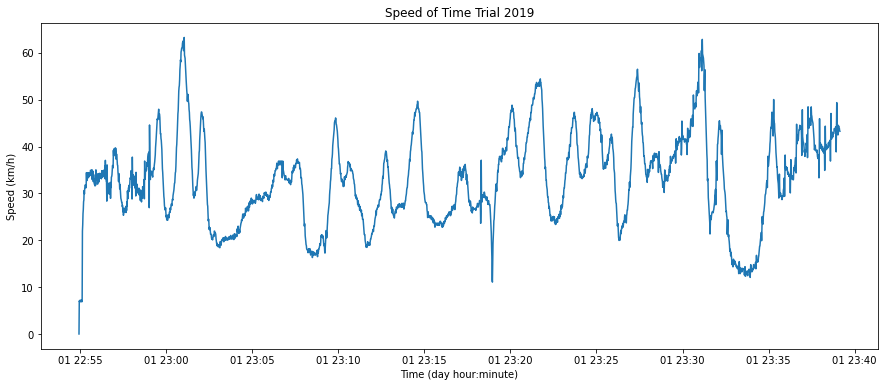

In [37]:
plt.figure(figsize = (15,6))
plt.title('Speed of Time Trial 2019')
speedPlot(tt_2019)

## Notes From Speed/Time Plots
* The races from 2016 seem to have outliers/glitches in the recordings with the sudden jump up (as seen in the graph)
* All of the races have a stop->start/acceleration point at the start, removing this would likely lead to a more accurate representation of the speed
* Both of the road races have a similar speed graph so are likely performed on the same course, this also applies to the time trials

### Removing Outliers
In order to provide a fairer comparison between these rides, I will create a new function that takes in each ride and removes speeds above 80kmph (Steve seems like a good cyclist but the sudden jumps to over 150kmph in the 2016 races seem unrealisic, especially because these are so different to the rest of the data. 80kmph seemed like a good cut off point for these jumps). I will also remove speeds under 10kmph in order to remove both the stop->start acceleration as well as any points where Steve stops. 

In [12]:
def remOutliers(dataframe):
    return dataframe[(dataframe['speed'] > 10) & (dataframe['speed'] < 80)]    

In [13]:
cleanRR_2016 = remOutliers(rr_2016)
cleanTT_2016 = remOutliers(tt_2016)
cleanRR_2019 = remOutliers(rr_2019)
cleanTT_2019 = remOutliers(tt_2019)

In [14]:
def compareSpeed(old, new):
    print("Average speed with outliers: ", round(old["speed"].mean(), 2), "km/h", sep = "")
    print("Average speed without outliers: ", round(new["speed"].mean(), 2), "km/h", sep = "")

In [15]:
def maxMinSpeed(data):
    print("The top speed of the ride was: ", round(data['speed'].max(),2), "km/h", sep = "")
    print("\n")

In [16]:
print("--Road Race 2016--")
compareSpeed(rr_2016, cleanRR_2016)
maxMinSpeed(cleanRR_2016)
print("--Time Trial 2016--")
compareSpeed(tt_2016, cleanTT_2016)
maxMinSpeed(cleanTT_2016)
print("--Road Race 2019--")
compareSpeed(rr_2019, cleanRR_2019)
maxMinSpeed(cleanRR_2019)
print("--Time Trial 2019--")
compareSpeed(tt_2019, cleanTT_2019)
maxMinSpeed(cleanTT_2019)

--Road Race 2016--
Average speed with outliers: 34.93km/h
Average speed without outliers: 34.94km/h
The top speed of the ride was: 70.71km/h


--Time Trial 2016--
Average speed with outliers: 33.53km/h
Average speed without outliers: 33.57km/h
The top speed of the ride was: 67.86km/h


--Road Race 2019--
Average speed with outliers: 33.88km/h
Average speed without outliers: 33.93km/h
The top speed of the ride was: 70.37km/h


--Time Trial 2019--
Average speed with outliers: 33.06km/h
Average speed without outliers: 33.18km/h
The top speed of the ride was: 63.3km/h




From this we can see that the time trials are slightly slower than the road races and also had higher top speeds. 

## Comparing Speeds of Time Trials
We will first get a quick overview of the two time trials speeds: 

In [17]:
print("--Time Trial 2016--")
summary(cleanTT_2016)
print("--Time Trial 2019--")
summary(cleanTT_2019)

--Time Trial 2016--
The overall distance was: 24.75kms
The total time taken was:  0 days 00:45:45
The average speed of the ride was: 33.57km/h


--Time Trial 2019--
The overall distance was: 24.36kms
The total time taken was:  0 days 00:44:02
The average speed of the ride was: 33.18km/h




From this we can see that although the average speed of the 2016 ride was slower than the 2019 ride, the total time was actually less for the 2019 ride

As suspected above, the time trials are likely on the same track. 
If we can plot the 2016 and 2019 races together, we will be able to see parts of the race in which the rider goes slower/faster between the races. 

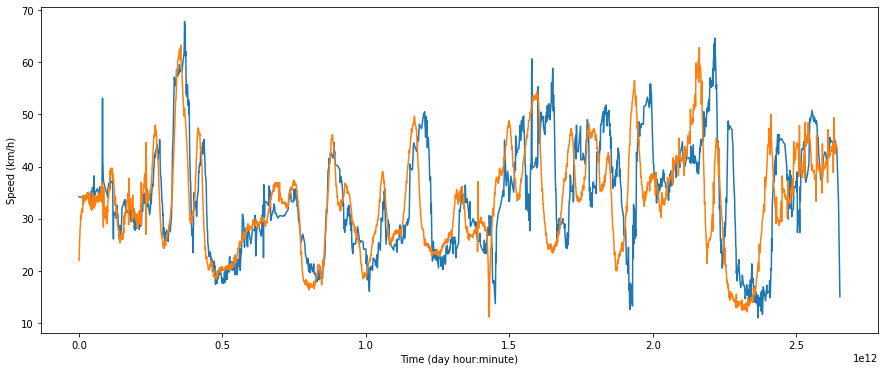

In [41]:
plt.figure(figsize = (15,6))
speedPlot(cleanTT_2016)
speedPlot(cleanTT_2019)

### Some notes from comparing the graphs
* The time scale is obviously different
* There are still obvious errors with the 2016 recording as it spikes and troughs randomly 
* These errors are likely contributing to the average speed value of the 2016 race

In order to fix these errors, I will take a rolling mean of both plots and compare them again:

In [42]:
def speedPlotClean(dataframe):
    dataframe['avSpeed'] = dataframe.speed.rolling(7).mean()
    sns.lineplot(data=dataframe, x =dataframe.index - dataframe.index[0], y = 'avSpeed')

<ipython-input-42-02707afa2a40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['avSpeed'] = dataframe.speed.rolling(7).mean()


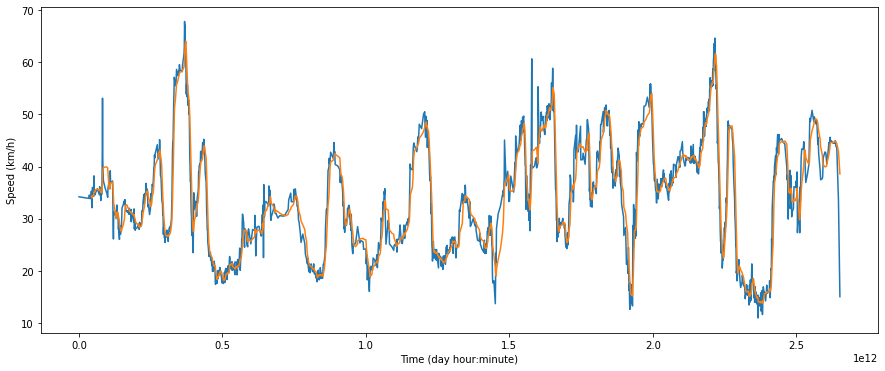

In [46]:
plt.figure(figsize = (15,6))
speedPlot(cleanTT_2016)
speedPlotClean(cleanTT_2016)

<ipython-input-42-02707afa2a40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['avSpeed'] = dataframe.speed.rolling(7).mean()


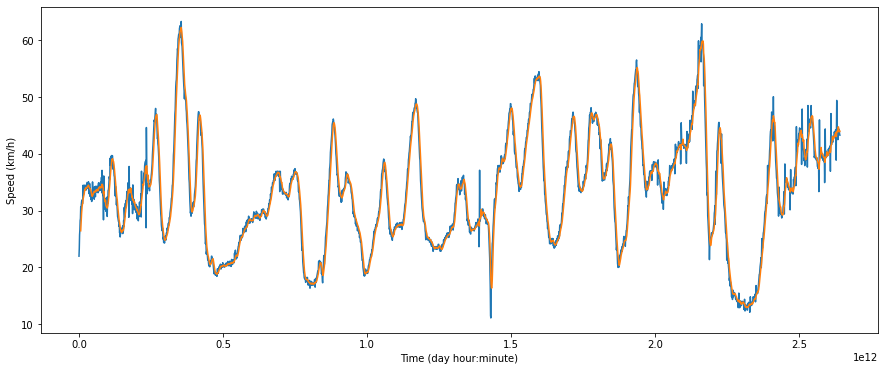

In [44]:
plt.figure(figsize = (15,6))
speedPlot(cleanTT_2019)
speedPlotClean(cleanTT_2019)

## Fairly Comparing The Time Trials
We will now plot a rolling mean of the 2016 and 2019 time trials to more clearly see where each race speeds up and slows down
I will also add an offset to the 2019 race to try to get them to line up better in the graph. 

<ipython-input-22-0836b802220b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt_2016Offset['speed'] = tt_2016Offset['speed'].shift(-20)
<ipython-input-19-02707afa2a40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['avSpeed'] = dataframe.speed.rolling(7).mean()


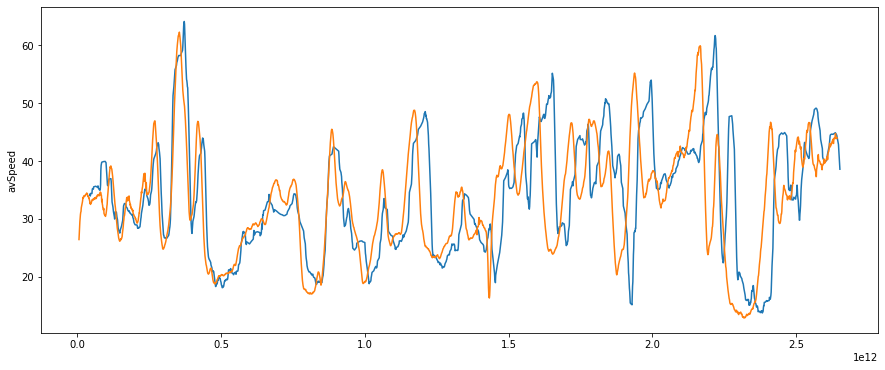

In [22]:
tt_2016Offset = cleanTT_2016
tt_2016Offset['speed'] = tt_2016Offset['speed'].shift(-20)
plt.figure(figsize = (15,6))
speedPlotClean(tt_2016Offset)
speedPlotClean(cleanTT_2019)

As we can see with these plots, the 2019 race starts off on par and at times faster than the 2016 race, then dips off toward the end of the race. 

### Summary Of Time Trials
* The 2016 Time Trial was on average faster than the 2019 Time Trial
* The 2019 Time Trial was faster at points but slowed down toward the end of the race

# Elevation Analysis
We will complete the following steps in order to break up the data sets into ascedning, descending and flat portions then take the average speed of each portion:
1. Create a new column that takes the gradient of each point in the elevation column
2. Divide this column up into seperate data frames (asc, dsc and flt). This division will be based on if the gradient is going up, down or staying flat
3. Graph the three portions, adjusting the degree of the gradient until it is accurate

In [23]:
def adf(dataframe, degree, outType):
    dataframe['a_d'] = np.gradient(dataframe['elevation'])
    asc = dataframe[dataframe.a_d > degree]
    dsc = dataframe[dataframe.a_d < -degree]
    flt = dataframe[(dataframe.a_d > -degree) & (dataframe.a_d < degree)]
    if(outType == 'plot'):
        sns.scatterplot(data=asc, x=asc.index, y='elevation')
        sns.scatterplot(data=dsc, x=dsc.index, y='elevation')
        sns.scatterplot(data=flt, x=flt.index, y='elevation')
    elif(outType == 'avSpeed'):
        print("Average speed while ascending: ", round(asc['speed'].mean(),2), "km/h", sep='')
        print("Average speed while descending: ", round(dsc['speed'].mean(),2), "km/h", sep = '')
        print("Average speed while flat: ", round(flt['speed'].mean(),2), "km/h", sep='')
        print("\n")


<ipython-input-23-1a45d0cf43e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['a_d'] = np.gradient(dataframe['elevation'])


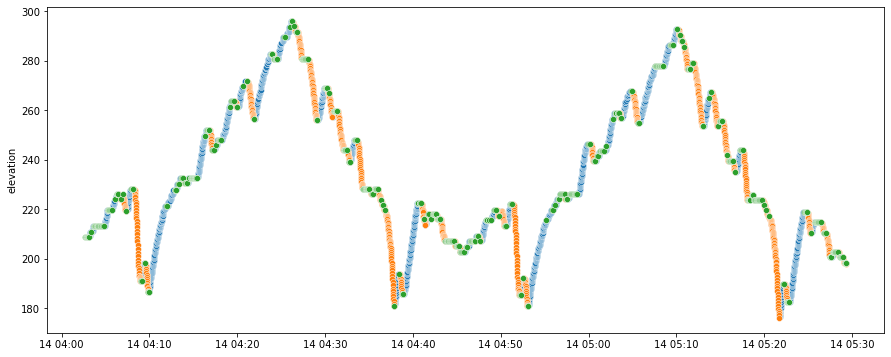

In [24]:
plt.figure(figsize = (15,6))
adf(cleanRR_2016, 0.1, 'plot')


In [25]:
print("--Road Race 2016--")
adf(cleanRR_2016, 0.1, 'avSpeed')
print("--Time Trial 2016--")
adf(cleanTT_2016, 0.1, 'avSpeed')
print("--Road Race 2019--")
adf(cleanRR_2019, 0.1, 'avSpeed')
print("--Time Trial 2019--")
adf(cleanTT_2019, 0.1, 'avSpeed')

--Road Race 2016--
Average speed while ascending: 26.59km/h
Average speed while descending: 45.39km/h
Average speed while flat: 35.05km/h


--Time Trial 2016--
Average speed while ascending: 29.06km/h
Average speed while descending: 38.95km/h
Average speed while flat: 34.88km/h


--Road Race 2019--
Average speed while ascending: 28.87km/h
Average speed while descending: 41.5km/h
Average speed while flat: 33.21km/h


--Time Trial 2019--
Average speed while ascending: 25.92km/h
Average speed while descending: 43.0km/h
Average speed while flat: 33.41km/h




<ipython-input-23-1a45d0cf43e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['a_d'] = np.gradient(dataframe['elevation'])
<ipython-input-23-1a45d0cf43e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['a_d'] = np.gradient(dataframe['elevation'])
<ipython-input-23-1a45d0cf43e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

## Challenge: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.





In [63]:
rr_2016["gear_ratio"] = rr_2016["speed"] / rr_2016[(rr_2016["cadence"] > 0)]
#dataframe[(dataframe['speed'] > 10)

ValueError: Wrong number of items passed 2833, placement implies 1